Step 1: Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

Step 2: Load Datasets

In [2]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

Step 3: Preprocessing

In [3]:
# Extract the release year from the movie title
movies_df['release_year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Compute average ratings for each movie
average_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Merge the movie data with their average ratings
movies_with_ratings = pd.merge(movies_df, average_ratings, on='movieId', how='left')

# Handle missing average ratings by filling with 0
movies_with_ratings['average_rating'] = movies_with_ratings['average_rating'].fillna(0)

# Preprocess 'genres' text for vectorization by cleaning special characters and converting to lowercase
movies_with_ratings['processed_text'] = movies_with_ratings['genres'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

Step 4: Vectorize the Text Data

In [4]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit transform the genre text data
sparse_X = vectorizer.fit_transform(movies_with_ratings['processed_text'])

Step 5: Define Cosine Similarity Logic

In [5]:
def retrieve_similar_movies(query, k=20):
    """
    Retrieve the top k most similar movies to the given query using cosine similarity
    sorted by average rating and release year.
    """
    # Transform the query string using the pre-fitted TF-IDF vectorizer
    query_vec = vectorizer.transform([query])
    
    # Compute cosine similarity
    cosine_sim = cosine_similarity(query_vec, sparse_X)  # Calculate similarity against all movies
    
    # Flatten the cosine similarity array to access all computed scores
    similarity_scores = cosine_sim.flatten()
    
    # Attach similarity scores to the DataFrame
    movies_with_ratings['similarity'] = similarity_scores

    # Sort by similarity, average rating, and release year
    sorted_movies = movies_with_ratings.sort_values(by=['similarity', 'average_rating', 'release_year'], 
                                                    ascending=[False, False, False])
    
    # Return the top k movies
    return sorted_movies.head(k)

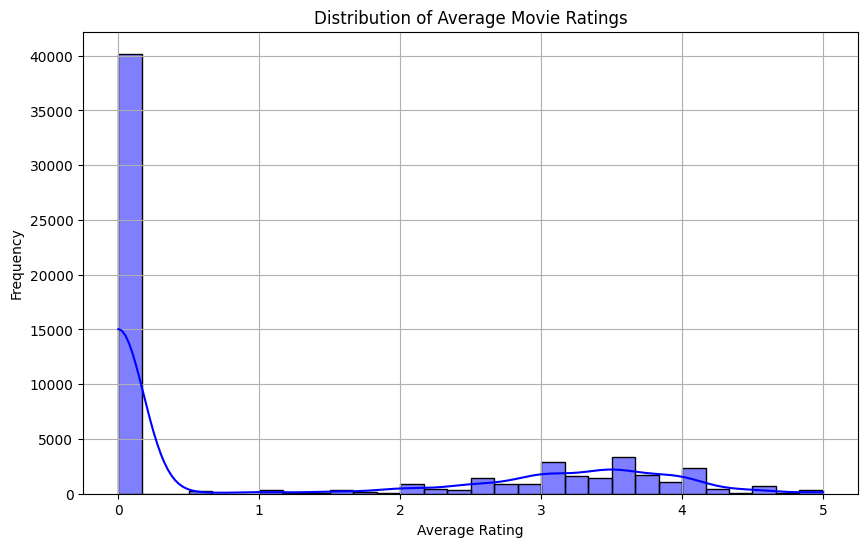

C:\Users\prana\AppData\Local\Temp\ipykernel_17760\3627960332.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


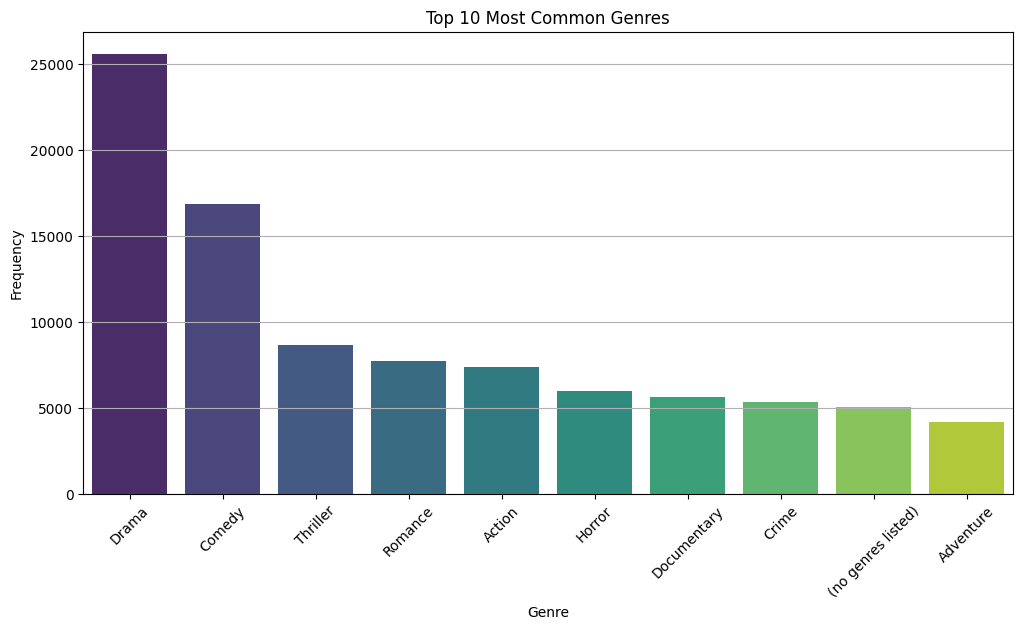

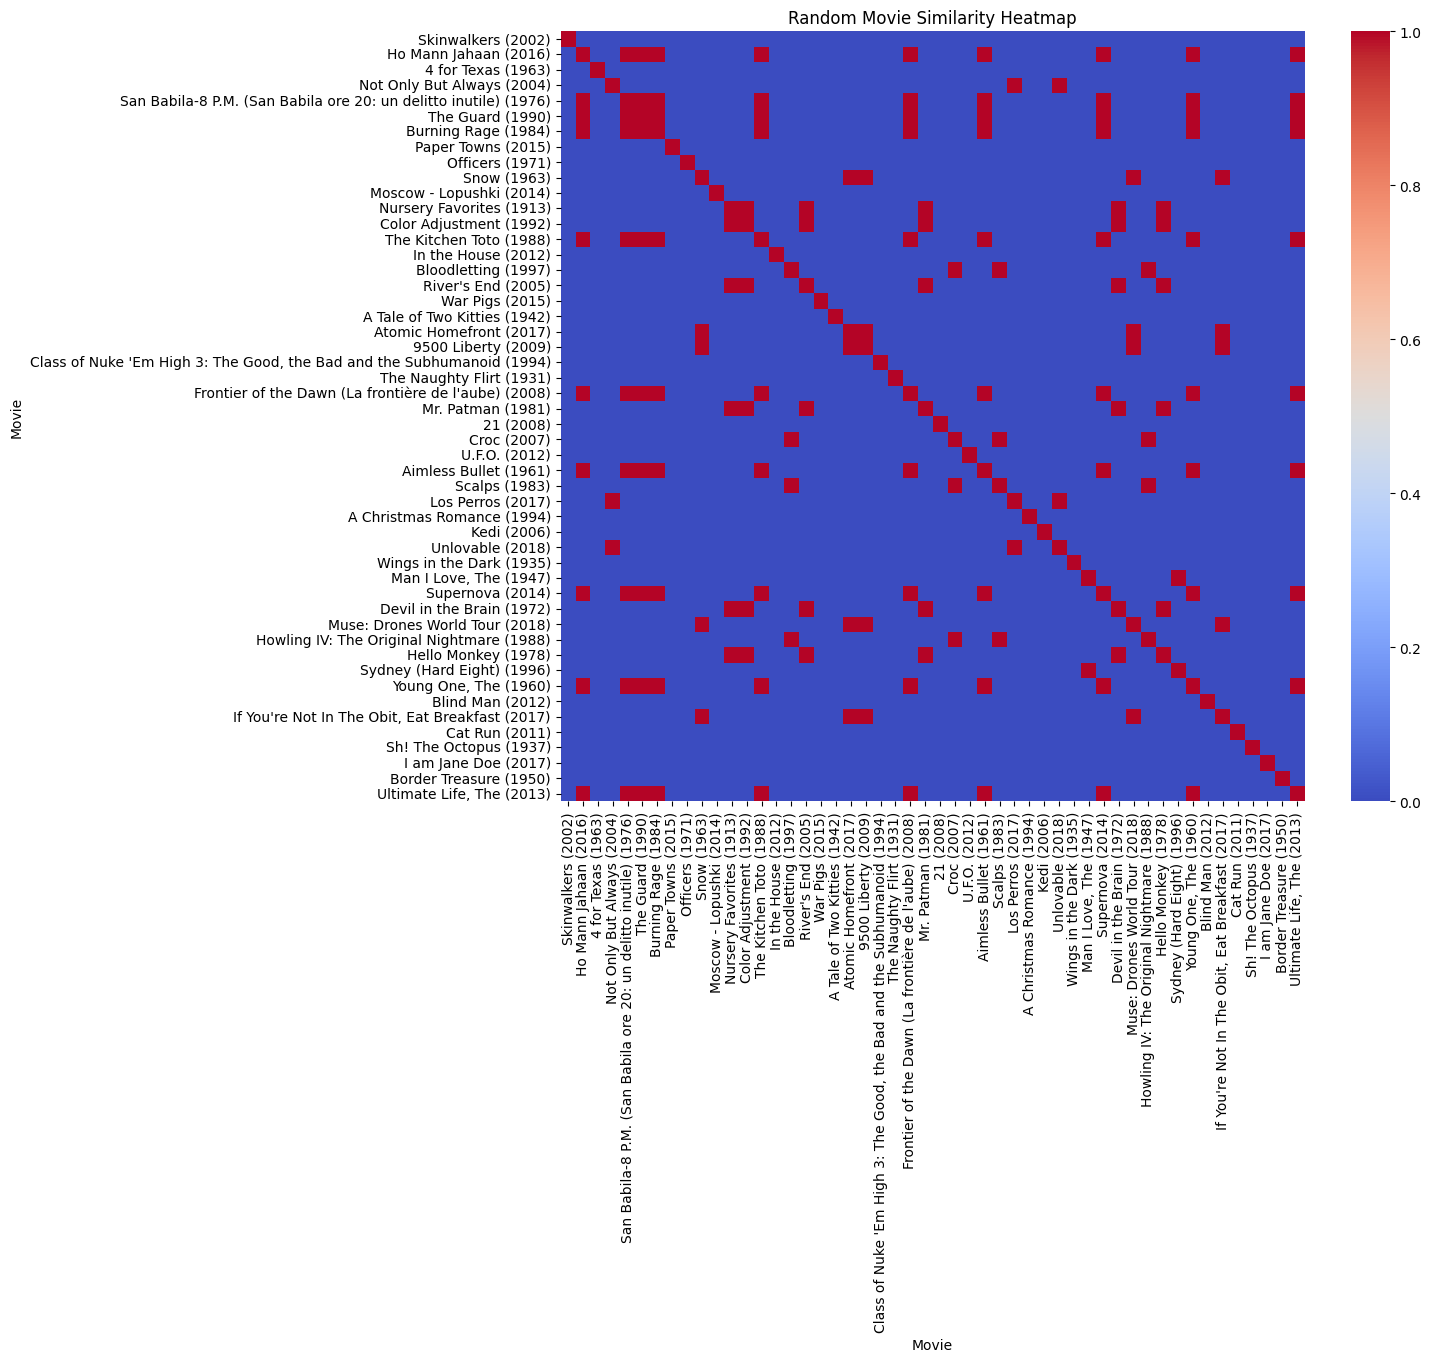

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Step 5: Visualizations
def plot_distributions():
    """
    Function to plot graphs and visualize insights about the movie recommendation dataset.
    """
    
    # Plot 1: Distribution of average movie ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(movies_with_ratings['average_rating'], bins=30, kde=True, color='blue')
    plt.title('Distribution of Average Movie Ratings')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Plot 2: Most common genres
    all_genres = movies_with_ratings['genres'].dropna().str.split('|').sum()
    genre_counts = pd.Series(all_genres).value_counts().head(10)  # Top 10 genres
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
    plt.title('Top 10 Most Common Genres')
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

    # Plot 3: Similarity scores heatmap example
    # Select random movies and compute a heatmap of their similarity scores
    random_movies = movies_with_ratings.sample(50)  # Select 50 random movies for plotting
    sim_matrix = cosine_similarity(sparse_X[random_movies.index])
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(sim_matrix, annot=False, cmap="coolwarm", xticklabels=random_movies['title'].values, 
            yticklabels=random_movies['title'].values)
    plt.title('Random Movie Similarity Heatmap')
    plt.xlabel('Movie')
    plt.ylabel('Movie')
    plt.show()

# Call the plotting functions
plot_distributions()


Step 6: Test the Recommendation Logic

In [8]:
# Example: Query with a test string
query = 'adventure'
similar_movies = retrieve_similar_movies(query)
print(f"Movies similar to the query '{query}':")
print(similar_movies[['title', 'genres', 'average_rating', 'release_year', 'similarity']])

query = 'comedy'
similar_movies = retrieve_similar_movies(query)
print(f"\nMovies similar to the query '{query}':")
print(similar_movies[['title', 'genres', 'average_rating', 'release_year', 'similarity']])

Movies similar to the query 'adventure':
                                                   title     genres  \
15013                             Treasure Island (1934)  Adventure   
27588                                  Wolf Totem (2015)  Adventure   
21357    Belle and Sebastien (Belle et Sébastien) (2013)  Adventure   
13145                                  Billy Budd (1962)  Adventure   
60446                    The Peanut Butter Falcon (2019)  Adventure   
34688                       Naval Cadets, Charge! (1987)  Adventure   
5733   Pursuit of D.B. Cooper, The (a.k.a. Pursuit) (...  Adventure   
6389                              Long Ships, The (1963)  Adventure   
55768                             The Black Arrow (1948)  Adventure   
12750               Adventures of Tom Sawyer, The (1938)  Adventure   
12480                           Wee Willie Winkie (1937)  Adventure   
5250                        Mountains of the Moon (1990)  Adventure   
920                            Mark 

Step 7: Save Processed Data

In [9]:
import pickle

# Save the processed data
with open('movies_with_ratings.pkl', 'wb') as f:
    pickle.dump(movies_with_ratings, f)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)